In [1]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.autonotebook import tqdm


import random
import numpy as np
import matplotlib.pyplot as plt
import sys

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(sys.version)  # Python 3.6
print(device)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
cuda:0


In [2]:
!pip freeze | grep torch

torch==1.5.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.6.0+cu101


## Notes on implementation
- $m_d = 1$ if data is observed
- $m_d = 0$ if data is missing

Masking operator $f_\tau$ with $\tau = 0$

Mask Generator $G_m$ with a sigmoid activation with temperature to allow gradient-based training, temperature $\lambda = 0.66$

Losses follow the Wasserstein GAN formulation
$D_x, D_m$ are both 1-Lipschitz for Wass GAN
- a few steps of optimizing the discriminators and 1 step of optimizing the generators
- $\alpha = 0.2$
- $\beta = 0.1$ when optimizing $G_x$
- default hyperparameters for WassGAN with gradient penalty



Imputer network $G_i$: 3-layer FC network with 500 hidden units in the middle
- trained for 1000 epochs for MNIST and CIFAR-10

Two options: 
- Conv-MisGAN following DCGAN architecture with 128-d latent code
- FC-MisGAN
- trained for 300 epochs
- Both options trained using the improved procedure for the Wass GAN with gradient penalty

## Dataset

Note: all three datasets, the pixel values are rescaled to $[0, 1]$

MNIST
- use 60000 training examples
- use LeNet model instead of the Inception network trained on ImageNet, and then take the 50-d output from the second-last FC layer as features

Evaluation metric: Frechet Inception Distance 


DCGAN Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## Helper Function

In [0]:
# code borrowed from MisGAN
def plot_grid(ax, image, image_size=28, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8, title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = image_size
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))
            
    if title:
        ax.set_title(title)

## MNIST Implementation

In [0]:
# hyperparameters
# From DCGAN paper
batch_size = 128

# From MisGAN
epochs = 300
latent_size = 128
temperature = 0.66
alpha = 0.2

# From WGAN-GP
penalty_lambda = 10
n_critic = 5

# Adam
adam_alpha = 0.0001
adam_beta_1 = 0.5
adam_beta_2 = 0.9

# our choice
image_size = 28
features = 64
length = 13

In [0]:
# Data Generator
class fcDataGenerator(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    # input is latent_size, going into a convolution
    self.fc1 = nn.Sequential(
      nn.Linear(latent_size, 256),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(256, 512),
      nn.ReLU()
    )
    self.fc3 = nn.Sequential(
      nn.Linear(512, image_size * image_size)
    )

  def forward(self, input):
    out = input.view(batch_size, -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    # use sigmoid as the data is scaled to [0, 1] (as suggested in MisGAN paper)
    out = torch.sigmoid(out)
    out = out.view(batch_size, 1, image_size, image_size)
    return out

In [0]:
# Mask Generator
class fcMaskGenerator(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    # input is latent_size, going into a convolution
    self.fc1 = nn.Sequential(
      nn.Linear(latent_size, 256),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(256, 512),
      nn.ReLU()
    )
    self.fc3 = nn.Sequential(
      nn.Linear(512, image_size * image_size)
    )

  def forward(self, input):
    out = input.view(batch_size, -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    # use sigmoid as the data is scaled to [0, 1] (as suggested in MisGAN paper)
    out = torch.sigmoid(out / temperature)
    out = out.view(batch_size, 1, image_size, image_size)
    return out

In [0]:
# Data Discriminator and Mask Discriminator
#TODO: check if the last layer is sigmoid or FC layer because of Wass GAN
# LayerNorm for WGAN-GP or no BatchNorm at all
class fcDiscriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Sequential(
      nn.Linear(image_size * image_size, 512),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(512, 256),
      nn.ReLU()
    )
    self.fc3 = nn.Sequential(
      nn.Linear(256, 128),
      nn.ReLU()
    )
    self.fc4 = nn.Sequential(
      nn.Linear(128, 1)
    )

    # linear activation for the last layer to predice the score of 'realness' given an image

  def forward(self, input):
    out = input.view(batch_size, -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.fc4(out)
    return out

In [0]:
# Load the MNIST Data and Create Missing Data


transform = transforms.Compose([
  transforms.Resize((image_size, image_size)),   # resize the image to the desired image size
  transforms.ToTensor(),  # transform an image to [0, 1] in the shape of (C, H, W)
])

# Square Missing data
class maskedSquareMNIST(Dataset):
  def __init__(self, length: int):
    super().__init__()
    self.length = length
    mnist = MNIST('./data', train=True, transform=transform, download=True)
    self.size = len(mnist)

    self.data = torch.empty(self.size, 1, image_size, image_size, dtype=torch.float)
    self.data_masked = torch.empty(self.size, 1, image_size, image_size, dtype=torch.float)
    self.mask = torch.zeros(self.size, 1, image_size, image_size, dtype=torch.float)

    for i, (img, label) in enumerate(mnist):
      # apply the random square mask
      self.mask[i][0].bernoulli_(p=0.5)
      # save the location of the mask
      # apply the mask to the image
      self.data_masked[i][0] = img * self.mask[i]
      # save the original image
      self.data[i][0] = img
  

  def __getitem__(self, i):
    # masked image (without the label), mask, index
    # return self.data_masked[i], self.mask[i], i
    return self.data[i], self.mask[i], i


  def __len__(self):
    return self.size


# Independent Dropout from a Bernoulli Distribution

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


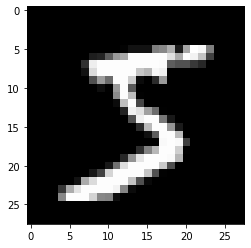

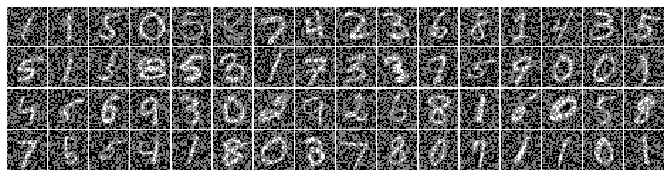

In [9]:
# Put the dataset into DataLoader

data = maskedSquareMNIST(length=length)
plt.imshow(data[0][0].squeeze(), cmap=plt.get_cmap('gray'))

# for visualisation purpose
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau


data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
data_samples, mask_samples, _ = next(iter(data_loader))
print(data_samples.shape)
print(mask_samples.shape)
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5), image_size=image_size, nrow=4, ncol=16)




In [0]:
# Create all the generators, discrimnators
G_data = fcDataGenerator(latent_size).to(device)
G_mask = fcMaskGenerator(latent_size).to(device)

D_data = fcDiscriminator().to(device)
D_mask = fcDiscriminator().to(device)


# Create all the optimisers
G_data_optimizer = optim.Adam(G_data.parameters(), lr=adam_alpha, betas=(adam_beta_1, adam_beta_2))
G_mask_optimizer = optim.Adam(G_mask.parameters(), lr=adam_alpha, betas=(adam_beta_1, adam_beta_2))

D_data_optimizer = optim.Adam(D_data.parameters(), lr=adam_alpha, betas=(adam_beta_1, adam_beta_2))
D_mask_optimizer = optim.Adam(D_mask.parameters(), lr=adam_alpha, betas=(adam_beta_1, adam_beta_2))



Epoch: 0


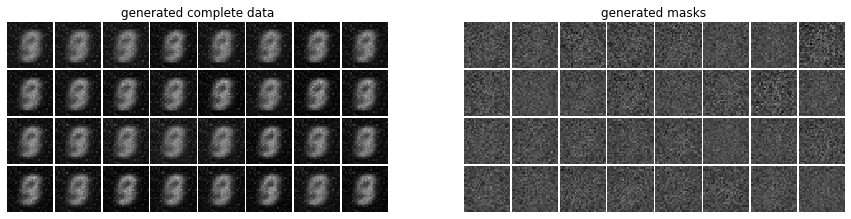


Epoch: 10


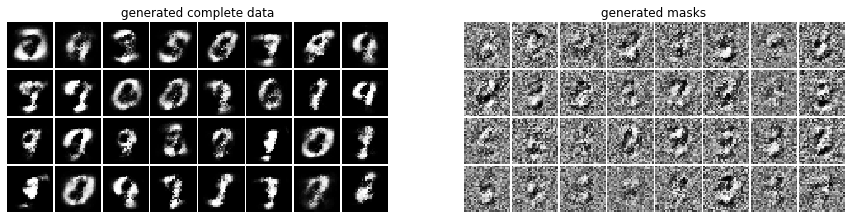


Epoch: 20


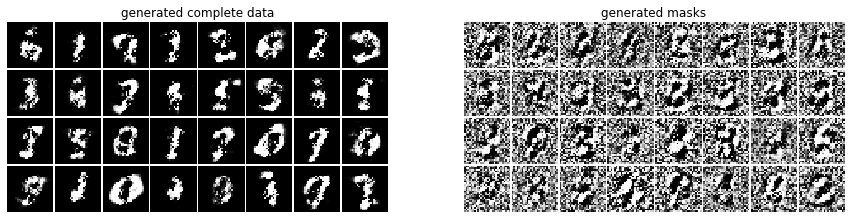


Epoch: 30


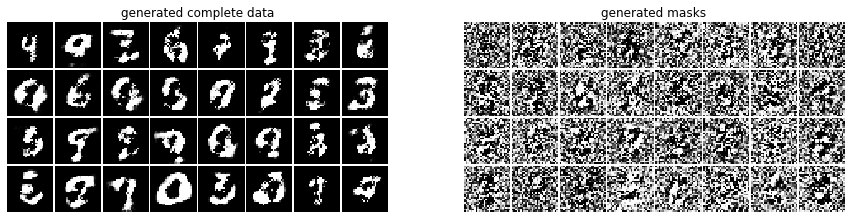


Epoch: 40


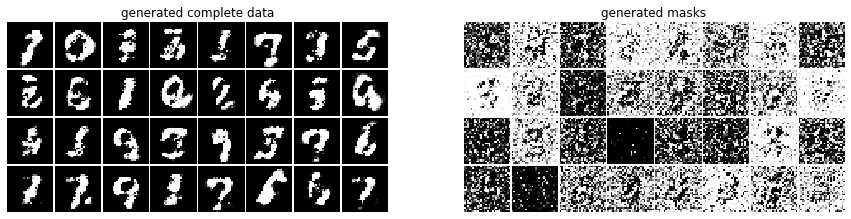

KeyboardInterrupt: ignored

In [11]:
plot_interval = 10
critic_updates = 0

# Initialise the latent space array in the generator
data_noise = torch.empty(batch_size, latent_size, 1, 1, dtype=torch.float).to(device)
mask_noise = torch.empty(batch_size, latent_size, 1, 1, dtype=torch.float).to(device)

# Initialise the epsilon for data interpolation
epsilons = torch.empty(batch_size, 1, 1, 1, dtype=torch.float).to(device)

# Define the update function for WGAN with gradient penalty
def gradient_penalty(disc, real, fake):
  # generate interpolated data with epsilons
  epsilons.uniform_(0, 1)
  data_itp = (real + (1 - epsilons) * fake).clone().detach().requires_grad_(True).to(device)

  # Compute WGAN Loss with Gradient Penalty
  gradients = autograd.grad(outputs=disc(data_itp), inputs=data_itp,
                            grad_outputs=torch.ones(batch_size, 1).to(device), create_graph=True)[0]
  gradients = gradients.view(batch_size, -1)
  gradient_penalty = penalty_lambda * ((gradients.norm(dim=1) - 1)**2).mean()

  return gradient_penalty

# update the discriminator for n_critic batches before updating the generator for one batch
for epoch in range(epochs):
  data_loader = tqdm(data_loader)
  for data_real, mask_real, _ in data_loader:

    # clear the gradient in Discriminators
    D_data_optimizer.zero_grad()
    D_mask_optimizer.zero_grad()
    
    # put real data to device
    data_real, mask_real = data_real.to(device), mask_real.to(device)
    # generate fake data
    data_noise.normal_(0, 1)
    mask_noise.normal_(0, 1)
    data_fake, mask_fake = G_data(data_noise), G_mask(mask_noise)
    # generate masked data
    data_masked_real = data_real * mask_real
    data_masked_fake = data_fake * mask_fake

    #################################################
    # Discriminators Loss: masked data and the mask #
    #################################################

    # data_masked: Compute WGAN Loss with Gradient Penalty
    penalty = gradient_penalty(D_data, data_masked_real.data, data_masked_fake.data)
    loss_data = D_data(data_masked_fake).mean() - D_data(data_masked_real).mean() + penalty
    loss_data.backward(retain_graph=True)
    D_data_optimizer.step()

    # mask: Compute WGAN Loss with Gradient Penalty
    penalty = gradient_penalty(D_mask, mask_real.data, mask_fake.data)
    loss_mask = D_mask(mask_fake).mean() - D_mask(mask_real).mean() + penalty
    loss_mask.backward(retain_graph=True)
    D_mask_optimizer.step()

    critic_updates += 1
    #############################################
    # Generators Loss: masked data and the mask #
    #############################################

    if critic_updates == n_critic:

      # clear the gradient in optimizers
      G_data_optimizer.zero_grad()
      G_mask_optimizer.zero_grad()

      # Update generators' parameters
      # for p in D_data.parameters():
      #   p.requires_grad_(False)
      # for p in D_mask.parameters():
      #   p.requires_grad_(False)

      # generate fake data
      data_noise.normal_(0, 1)
      mask_noise.normal_(0, 1)

      data_fake, mask_fake = G_data(data_noise), G_mask(mask_noise)
      # generate masked data
      data_masked_fake = data_fake * mask_fake

      # Compute the loss on G_data
      loss_data_G = -1 * D_data(data_masked_fake).mean()
      loss_data_G.backward(retain_graph=True)

      # Compute the loss on G_mask
      loss_mask_G = -1 * D_mask(mask_fake).mean()
      (loss_mask_G + loss_data_G * alpha).backward()

      G_data_optimizer.step()
      G_mask_optimizer.step()

      critic_updates = 0
      # Update generators' parameters
      # for p in D_data.parameters():
      #   p.requires_grad_(True)
      # for p in D_mask.parameters():
      #   p.requires_grad_(True)


  if epoch % plot_interval == 0:
      # Although it makes no difference setting eval() in this example, 
      # you will need those if you are going to use modules such as 
      # batch normalization or dropout in the generators.
      G_data.eval()
      G_mask.eval()

      with torch.no_grad():
          print('Epoch:', epoch)
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
          
          data_noise.normal_()
          data_samples = G_data(data_noise)
          plot_grid(ax1, data_samples, title='generated complete data')
          
          mask_noise.normal_()
          mask_samples = G_mask(mask_noise)
          plot_grid(ax2, mask_samples, title='generated masks')
          
          plt.show()
          plt.close(fig)

      G_data.train()
      G_mask.train()

print("Done training")
torch.save(G_data.state_dict(), "G_data_"+str(length))
torch.save(G_mask.state_dict(), "G_mask_"+str(length))
torch.save(D_data.state_dict(), "D_data_"+str(length))
torch.save(D_mask.state_dict(), "D_mask_"+str(length))


In [0]:
G_data.eval()
G_mask.eval()

with torch.no_grad():
    print('Epoch:', epoch)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    data_noise.normal_()
    data_samples = G_data(data_noise)
    plot_grid(ax1, data_samples, title='generated complete data')
    
    mask_noise.normal_()
    mask_samples = G_mask(mask_noise)
    plot_grid(ax2, mask_samples, title='generated masks')
    
    plt.show()
    plt.close(fig)

G_data.train()
G_mask.train()